In [1]:
%matplotlib inline


# Restricted Boltzmann Machine features for digit classification


For greyscale image data where pixel values can be interpreted as degrees of
blackness on a white background, like handwritten digit recognition, the
Bernoulli Restricted Boltzmann machine model (:class:`BernoulliRBM
<sklearn.neural_network.BernoulliRBM>`) can perform effective non-linear
feature extraction.

In order to learn good latent representations from a small dataset, we
artificially generate more labeled data by perturbing the training data with
linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM
feature extractor and a :class:`LogisticRegression
<sklearn.linear_model.LogisticRegression>` classifier. The hyperparameters
of the entire model (learning rate, hidden layer size, regularization)
were optimized by grid search, but the search is not reproduced here because
of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The
example shows that the features extracted by the BernoulliRBM help improve the
classification accuracy.



Automatically created module for IPython interactive environment
[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.65s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 1.08s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 1.03s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.79s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.78s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.79s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.78s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.78s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.78s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.77s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -20.08, time = 0.78s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -19.82, time = 0.77s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19.64, time = 0.77s
[BernoulliRBM] Iteration 14, pseud

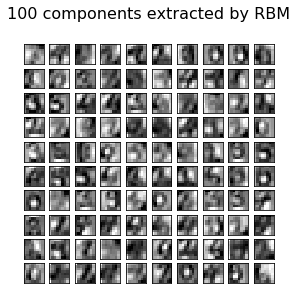

In [2]:
from __future__ import print_function

print(__doc__)

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
digits = datasets.load_digits()
X = np.asarray(digits.data, 'float32')
X, Y = nudge_dataset(X, digits.target)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [3]:
X,Y = nudge_dataset(X, Y)
Y

array([0, 1, 2, ..., 8, 9, 8])

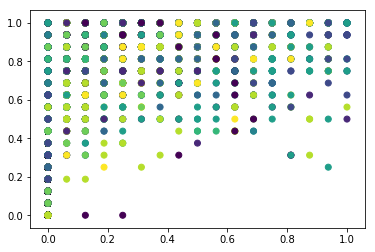

In [4]:
plt.scatter(X[:,0],X[:,1],c=Y)

In [5]:
X_train.shape

(7188, 64)

In [6]:
Y_train.shape

(7188,)

In [7]:
m = Y_train.shape[0]
Y_train_hot = np.zeros((65,m))
for i in range(m):
    index = Y_train[i]
    Y_train_hot[index,i] = 1

In [8]:
Y_train_hot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [9]:
np.eye(m,65)[Y_train]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [10]:
def softmax(z):
    t = np.exp(z)
    sum_t = np.sum(t,axis=0)
    return t/sum_t

In [11]:
m,n = X_train.shape
w = np.random.rand(65,n)
b = np.zeros((65,1))
z = np.dot(w,X_train.T) + b
A = softmax(z)
loss = -np.sum(Y_train_hot * np.log(A)) / m


In [12]:
b.shape

(65, 1)

In [13]:
w = w - 0.1* (np.dot(A-Y_train_hot,X_train)) / m
b = b - 0.1* (np.sum(A-Y_train_hot,axis=1,keepdims=True)) / m

In [23]:
w,b

(array([[0.42218464, 0.45290452, 0.78776861, ..., 0.19619268, 0.22833482,
         0.76735392],
        [0.03731955, 0.79411741, 0.82796714, ..., 0.58286765, 0.18674332,
         0.6235729 ],
        [0.82576655, 0.98819424, 0.73406207, ..., 0.96325958, 0.0833273 ,
         0.57661903],
        ...,
        [0.82599453, 0.3941084 , 0.15051642, ..., 0.10228191, 0.59365112,
         0.1055627 ],
        [0.07756272, 0.28949707, 0.98332941, ..., 0.93174358, 0.04844137,
         0.11765963],
        [0.28244733, 0.03455319, 0.15748497, ..., 0.29659339, 0.88368015,
         0.7284836 ]]), array([[ 0.05073071],
        [ 0.05896889],
        [ 0.05166589],
        [ 0.03347458],
        [ 0.04682088],
        [ 0.0467675 ],
        [ 0.03838934],
        [ 0.04176844],
        [ 0.04487545],
        [ 0.05539913],
        [-0.00743575],
        [-0.00707001],
        [-0.00852514],
        [-0.01249768],
        [-0.01294515],
        [-0.02533149],
        [-0.00271384],
        [-0.0026053

In [38]:
def softmax(z):
    t = np.exp(z)
    sum_t = np.sum(t,axis=0)
    return t/sum_t

In [39]:
def LR_softmax(X,Y,alpha,Iter):
    
    m,n = X.shape
    w = np.random.rand(65,n)
    b = np.zeros((65,1))
    cost = []
    
    for i in range(Iter):
        z = np.dot(w,X.T) + b
        A = softmax(z)
       # print(A.shape)
        #print(Y_hot.shape)
        loss = -np.sum(Y * np.log(A)) / m
        if i % 10 == 0:
            cost.append(loss)
    
        w = w - alpha* (np.dot(A-Y,X)) / m
        b = b - alpha* (np.sum(A-Y,axis=1,keepdims=True)) / m
        
    plt.plot(cost,c='orange')
    plt.title('Learning rate:{}'.format(alpha))    
    plt.xlabel('#Iter')
    plt.ylabel('value')
    return w,b

(array([[0.12070785, 0.74660458, 0.2010145 , ..., 0.02325662, 0.77795287,
         0.38474115],
        [0.88201731, 0.65597692, 0.41856456, ..., 0.96642169, 0.56776117,
         0.94530709],
        [0.65513423, 0.4761814 , 0.66454228, ..., 0.04860744, 0.12811089,
         0.04362151],
        ...,
        [0.4613589 , 0.28002677, 0.23105218, ..., 0.07257579, 0.3524524 ,
         0.59897278],
        [0.16065667, 0.08551396, 0.01691776, ..., 0.05089515, 0.91156447,
         0.55299101],
        [0.40764811, 0.93413262, 0.08144748, ..., 0.14683727, 0.67554717,
         0.64293257]]), array([[ 0.0459683 ],
        [ 0.04467476],
        [ 0.03823226],
        [ 0.0474818 ],
        [ 0.04716388],
        [ 0.03934932],
        [ 0.04083866],
        [ 0.03797817],
        [ 0.04466476],
        [ 0.01634187],
        [-0.00980988],
        [-0.02550219],
        [-0.01252634],
        [-0.00920282],
        [-0.00558181],
        [-0.00610229],
        [-0.0177448 ],
        [-0.0026134

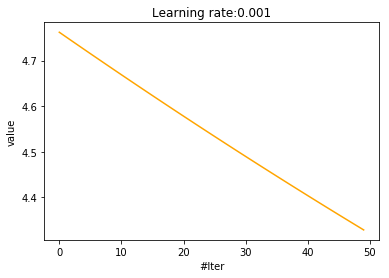

In [40]:
w,b = LR_softmax(X_train,Y_train_hot,0.001,500)
w,b

In [41]:
def score(X,Y,w,b):
    m,n = X.shape
    z = np.dot(w,X.T) + b
    A = softmax(z)
    predict = np.argmax(A,axis=0)
   # print(predict)
    accuracy = (Y==predict).sum() / m
    return accuracy

In [42]:
m = Y_train.shape[0]
Y_train_hot = np.zeros((65,m))
for i in range(m):
    index = Y_train[i]
    Y_train_hot[index,i] = 1

In [43]:
loss = score(X_train,Y_train_hot,w,b)
loss

0.06455203116304953

In [44]:
m = Y_test.shape[0]
Y_test_hot = np.zeros((65,m))
for i in range(m):
    index = Y_test[i]
    Y_test_hot[index,i] = 1

In [45]:
loss = score(X_test,Y_test_hot,w,b)
loss

0.037840845854201444